<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_SegmentationModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING COMPUTER VISION : Segmentation Models

In this notebook, I implemented the execution of the `segmentation models` library with a binary segmentation.

The `segmentation models` library is a python library with Neural Networks for Image Segmentation based on Keras and TensorFlow.

[Github](https://github.com/qubvel/segmentation_models)

Based in: [notebook1](https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb) [notebook2](https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb)

## Installation

Reqirements
 * keras >= 2.2.0 or tensorflow >= 1.13
 * segmenation-models==1.0.*
 * albumentations==0.3.0


In [0]:

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U "albumentations>=0.3.0" --user 

# I don't know why but in google colab I am not able to download the >=0.3.0 version 
#   ==> SOLUTION: dowload the latest version from the official git
!pip install -U git+https://github.com/albu/albumentations

In [3]:
import albumentations
albumentations.__version__

'0.4.5'

In [0]:
!pip install -U --pre segmentation-models --user

In [5]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

## Definition

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

## Dataset

The common format used by most of the datasets and keras_segmentation is the combination of input RGB images and the corresponding segmentation images.

In the segmentation masks, the pixel value should denote the class ID of the corresponding pixel. So, previosly we assign each class a unique ID. 

For the segmentation maps, do not use the jpg format as jpg is lossy and the pixel values might change. Use bmp or png format instead. And of course, the size of the input image and the segmentation image should be the same.

![segmentation-classes](https://camo.githubusercontent.com/7ef8ef2bb8b8072670e6b86d330c9a9ba22c499a/68747470733a2f2f646976616d67757074612e636f6d2f6173736574732f696d616765732f706f7374732f696d677365672f696d61676531342e706e673f7374796c653d63656e7465726d65)

For this example we will use **CamVid** dataset. It is a set of:

* train images + segmentation masks
* validation images + segmentation masks
* test images + segmentation masks

All images have 320 pixels height and 480 pixels width. For more information about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.







In [0]:
camvid_classes = {
    'sky' : 0,
    'building' : 1,
    'pole' : 2,
    'road' : 3,
    'pavement' : 4,
    'tree' : 5,
    'signsymbol' : 6,
    'fence' : 7,
    'car' : 8,
    'pedestrian' : 9,
    'bicyclist' : 10,
    'unlabelled' : 11,
}

In [8]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [9]:
!ls {DATA_DIR}

test  testannot  test.txt  train  trainannot  train.txt  val  valannot	val.txt


Filepaths to each kind of image-mask dataset: train, validation, test

In [0]:
#Train
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

#Validation
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

#Test
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

Filenames of each kind of image-mask dataset: train, validation, test

In [0]:
#Train
x_train_ids = os.listdir(x_train_dir)
y_train_ids = os.listdir(y_train_dir)

#Validation
x_valid_ids = os.listdir(x_valid_dir)
y_valid_ids = os.listdir(y_valid_dir)

#Test
x_test_ids = os.listdir(x_test_dir)
y_test_ids = os.listdir(y_test_dir)

### Validate dataset

Each image has to have the corresponding segmentation mask.

In [12]:
print(f'Number of training images-annotations : {len(x_train_ids)}-{len(y_train_ids)}')
print(f'Number of validation images-annotations : {len(x_valid_ids)}-{len(y_valid_ids)}')
print(f'Number of test images-annotations : {len(x_test_ids)}-{len(y_test_ids)}')

Number of training images-annotations : 367-367
Number of validation images-annotations : 101-101
Number of test images-annotations : 233-233


In [0]:
import collections
#Check if two list have exactly the same values
assert collections.Counter(x_train_ids) == collections.Counter(y_train_ids)
assert collections.Counter(x_valid_ids) == collections.Counter(y_valid_ids)
assert collections.Counter(x_test_ids) == collections.Counter(y_test_ids)

## Utility functions

Functions that are used in different context of this code and represet common functionalities.

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

The problem in the vsualization of one mask is the labels (0,1,2, ...) are consecutive, that means in RGB terms, the image has segment with pixels: 0,0,0 ; 1,1,1 ; 2,2,2 ; ... For the human eye, these variations are not easily perceived.

The trick is use only one channel of the RGB, because matplotlib automatically plot human-friendly visualization of this arrays.

In [0]:
def visualize_mask(seg):
    b, g, r    = cv2.split(seg)
    visualize(mask=b)


When we visualize a combination of image-segmentation pair we have the same problem of the previous visualization (human perception).

My trick, get the RGB channels of the segmentation file individually and multiply them by different modifiers previously to the fusion with the image.

In [0]:
def visualize_fused_image_mask(img, seg):
    #Split channels and modify each of them by some modifier
    b, g, r    = cv2.split(seg) 
    altered_seg = np.dstack((r*21,g*56,b*74))

    fused_img = (img/2 + altered_seg/2).astype('uint8')

    visualize(fused_image=fused_img)

### Test visualization function 

In [0]:
# First of all, we select the image-segmentation pair to visualize.
it_visualize = 10

img = cv2.imread(x_train_dir+"/"+x_train_ids[it_visualize])
seg = cv2.imread(y_train_dir+"/"+x_train_ids[it_visualize])

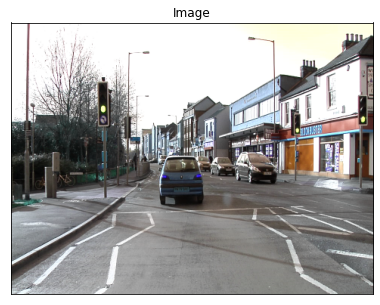

In [19]:
visualize(image=img)

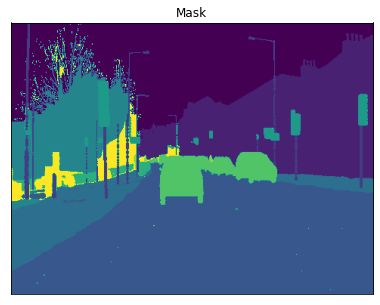

In [20]:
visualize_mask(seg)

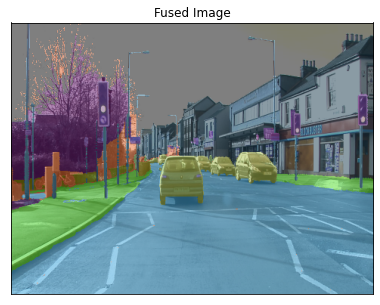

In [21]:
visualize_fused_image_mask(img, seg)

## Dataloader

These classes are dependent of the particular dataset. They have internally defined the relation label_name - label_id (param `CLASSES` in the class `Dataset`).

You should change this dependence to adapt this loader to your dataset. 

In [0]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
        
    ## CHANGE IT TO YOUR LABELS
    global camvid_classes
    CLASSES_DICT = camvid_classes
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES_DICT[cls.lower()] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [0]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Test dataloader and visualization

In [0]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky', 'pedestrian'])

In [0]:
image, mask = dataset[3] # get some sample

In [26]:
image.shape

(360, 480, 3)

The mask has a channel by each class (+1 by background). For example, if in our example we consider 3 classes ('car', 'sky', 'pedestrian') the mask has 4 channels (+1 by background). The position of each channel corresponds with the position of our class definition: 

  >in the input class array ['car', 'sky', 'pedestrian'] we have a mask where: position 0 is 'car', position 1 is 'sky', position 2 is 'pedestrian', position 3 is 'background'.

In [27]:
mask.shape

(360, 480, 4)

We visualize the image and some masks (masks are identified by the channel).

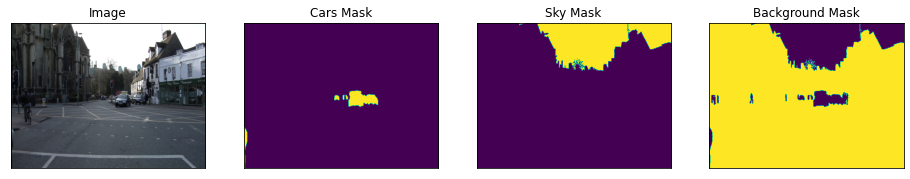

In [28]:
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

## Augmentation

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
If you not familiar with such trick read some of these articles:

* [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
* [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
* [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:

* horizontal flip
* affine transforms
* perspective transforms
* brightness/contrast/colors manipulations
* image bluring and sharpening
* gaussian noise
* random crops

All this transforms can be easily applied with [Albumentations](https://github.com/albu/albumentations/) - fast augmentation library. For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by Albumentations authors.

In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Test augmentation

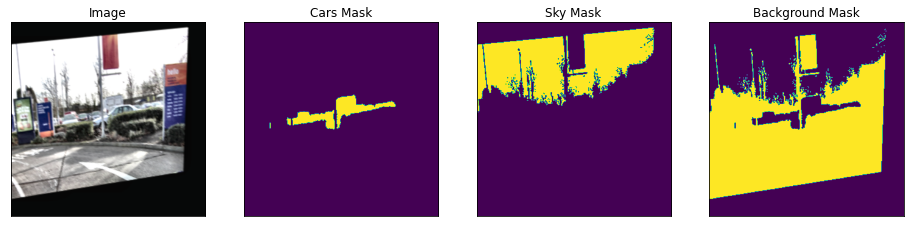

In [21]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

##  Segmentation model training

We are going to extend and structure the process of train a model from scratch. This process can be summarized in:

```
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_val, y_val),
)
```

In [22]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


### Classes (labels)

We can train a binary or a multiclass segmentation model. That dependes of the number of considered classes:

In [0]:
## Binary ==> Only one class (ex., car and no-car)
CLASSES = ['car']

## Multiclass ==> More than one class
# CLASSES = ['car', 'pedestrian']

In [0]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

This model considers all the dataset has the same dimension. In other case we should include a process of resize.

In [0]:
# check shapes for errors (CamVid shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

### Preprocess input dataset

* [Backbones](https://github.com/qubvel/segmentation_models#models-and-backbones): the feature extracting network which is used within the deeplab architecture (see the list in the [github](https://github.com/qubvel/segmentation_models#models-and-backbones))


In [0]:
BACKBONE = 'efficientnetb3'

preprocess_input = sm.get_preprocessing(BACKBONE)

We use the defined Dataset class and the backbone (feature extracting network) process.

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

### Define the model

* [Models](https://github.com/qubvel/segmentation_models#models-and-backbones)

 - [Unet](https://segmentation-models.readthedocs.io/en/latest/api.html#unet)
 - [FPN](https://segmentation-models.readthedocs.io/en/latest/api.html#fpn)
 - [Linknet](https://segmentation-models.readthedocs.io/en/latest/api.html#linknet)
 - [PSPNet](https://segmentation-models.readthedocs.io/en/latest/api.html#pspnet)

In general, the main parameters are equal for all the models but you can review the documentation page of each of them (click in the model name) to study the particular parameters. 

UNET, FPN and Linknet don't need you define the input shape: ```just pass (None, None, C) to make your model be able to process images af any size, but H and W of input images should be divisible by factor 32.```. The default value is ```input_shape=(None, None, 3)```. The C=3 is because by default the model waits RGB images. If you don't have RGB images ( C != 3 ) then : [link](https://segmentation-models.readthedocs.io/en/latest/tutorial.html#training-with-non-rgb-data).

We have to define the BACKBONE process used in the preprocessing of the input dataset.

In [25]:
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 2s 0us/step


### Training configuration

 * Hyperparameters

In [0]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 40

 * [Training callback](https://keras.io/callbacks/) 

In [0]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

 * [Optimizer](https://keras.io/optimizers/)

In [0]:
# define optimizer
optim = keras.optimizers.Adam(LR)

 * [Loss function](https://segmentation-models.readthedocs.io/en/latest/api.html#losses)

In [0]:
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

 * [Metrics](https://segmentation-models.readthedocs.io/en/latest/api.html#metrics)

In [0]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

* Compile the model

In [0]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

### Training process

Now, we have all the data and configuration to train the data.

In [28]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
45/45 [==============================] - 71s 2s/step - loss: 0.8798 - iou_score: 0.2727 - f1-score: 0.4056 - val_loss: 1.7592 - val_iou_score: 0.0214 - val_f1-score: 0.0409
Epoch 2/40
45/45 [==============================] - 27s 596ms/step - loss: 0.7266 - iou_score: 0.5707 - f1-score: 0.7200 - val_loss: 0.9842 - val_iou_score: 0.2065 - val_f1-score: 0.3075
Epoch 3/40
45/45 [==============================] - 27s 599ms/step - loss: 0.6129 - iou_score: 0.6710 - f1-score: 0.7972 - val_loss: 0.8926 - val_iou_score: 0.4985 - val_f1-score: 0.6092
Epoch 4/40
45/45 [==============================] - 27s 602ms/step - loss: 0.5352 - iou_score: 0.7140 - f1-score: 0.8279 - val_loss: 0.8489 - val_iou_score: 0.4845 - val_f1-score: 0.6188
Epoch 5/40
45/45 [==============================] - 27s 602ms/step - loss: 0.4354 - iou_score: 0.7621 - f1-score: 0.8629 - val_loss: 0.7748 - val_iou_score: 0.6385 - val_f1-score: 0.7302
Epoch 6/40
45/45 [==============================] - 27s 604ms/step -

### Visualize training metrics result

 - The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. This metric is closely related to the Dice coefficient which is often used as a loss function during training.

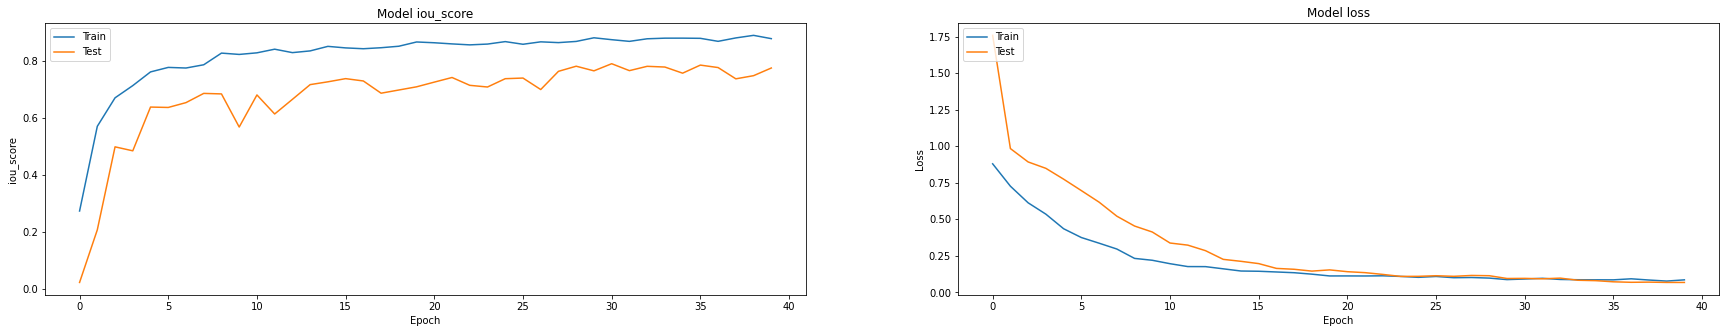

In [29]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Fine tuning process

If you want reuse some pretrained model, you have to define the pretrained model in the parameter `encoder_weights` when you declare the model. The pretrained model used is the [ImageNet](https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/).

```
from segmentation_models import Unet

model = Unet('resnet34', encoder_weights='imagenet')
```

Some times, it is useful to train only randomly initialized decoder in order not to damage weights of properly trained encoder with huge gradients during first steps of training. In this case, all you need is just pass encoder_freeze = True argument while initializing the model

```
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True)
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

# pretrain model decoder
model.fit(x, y, epochs=2)

# release all layers for training
set_trainable(model) # set all layers trainable and recompile model

# continue training
model.fit(x, y, epochs=100)
```


## Model Evaluation

In [0]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [0]:
# load best weights
model.load_weights('best_model.h5')

In [32]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.30804
mean iou_score: 0.78143
mean f1-score: 0.85325


## Visualization of results on test dataset - Prediction

### Binary model

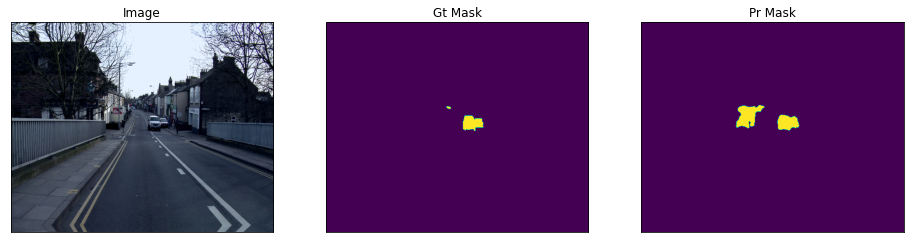

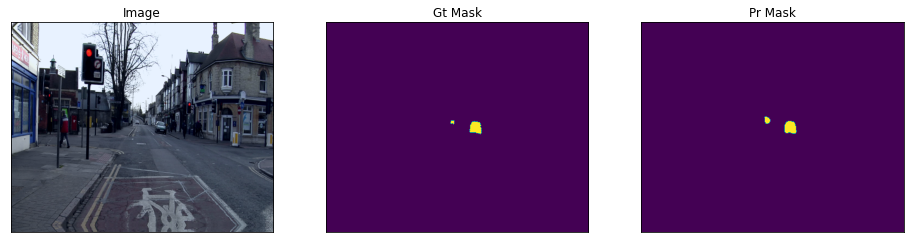

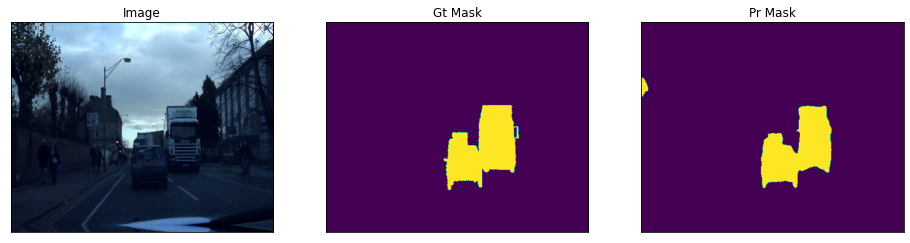

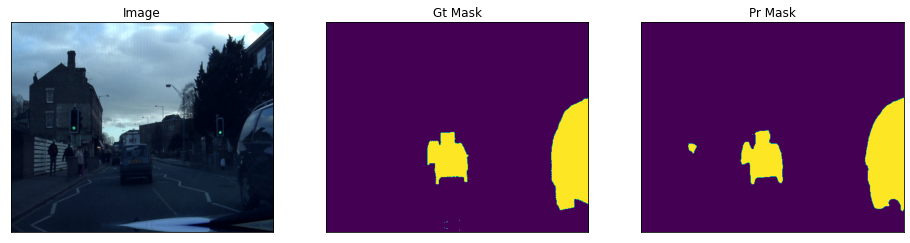

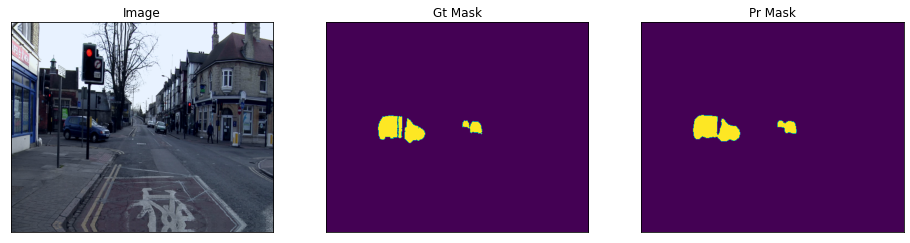

In [43]:
if n_classes == 1 :
    n = 5
    ids = np.random.choice(np.arange(len(test_dataset)), size=n)

    for i in ids:
        
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image).round()
        
        visualize(
            image=denormalize(image.squeeze()),
            gt_mask=gt_mask[..., 0].squeeze(),
            pr_mask=pr_mask[..., 0].squeeze(),
        )

### Multiclass model

In [0]:
if n_classes > 1 :
    n = 5
    ids = np.random.choice(np.arange(len(test_dataset)), size=n)

    for i in ids:
        
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        
        visualize(
            image=denormalize(image.squeeze()),
            gt_mask=gt_mask.squeeze(),
            pr_mask=pr_mask.squeeze(),
        )